In [2]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [7]:
4*np.ones((5,))

array([4., 4., 4., 4., 4.])

In [2]:
def charging_session(n): #Simulate Charging session from distribution
    norm_params = np.array([[5, 1],
                            [1, 1.3],
                            [9, 1.3]])
    n_components = norm_params.shape[0]
    # Weight of each component, in this case all of them are 1/3
    weights = np.ones(n_components, dtype=np.float64) / 3.0
    # A stream of indices from which to choose the component
    mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
    print(np.shape(mixture_idx))
    # y is the mixture sample
    y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)

    # Theoretical PDF plotting -- generate the x and y plotting positions
    xs = np.linspace(y.min(), y.max(), 200)
    ys = np.zeros_like(xs)
    print(np.shape(ys))

    for (l, s), w in zip(norm_params, weights):
        ys += ss.norm.pdf(xs, loc=l, scale=s) * w

    plt.plot(xs, ys)
    plt.hist(y, normed=True, bins="fd")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

    arr_time=ys
    dep_time=xs

    return arr_time, dep_time

def charging_session_individual(lambda_val, vehicle_capacity): #Simulate Charging session from distribution
    arr_time=(np.random.poisson(lam=lambda_val)+5.0)*12.0+np.random.randint(0.0, 12.0)
    sess_time=np.random.randint(1.0, 15.0)*12.0+np.random.randint(0.0, 12.0)
    init_cap=np.random.uniform(0.0, vehicle_capacity-1.0)
    req_energy=np.random.uniform(init_cap+0.5, vehicle_capacity)
    return arr_time, sess_time, init_cap, req_energy

In [27]:
#One day has 24*4(15 minutes) = 96 slots
n = 10000
np.random.seed(0)
num_steps = 96
decay_rate = 0.05
max_power = 0.6

total_vehicles = 50
battery_capacity = 8.0
power_capacity = 4

In [28]:
arrival_time=np.random.poisson(lam=9.0, size=(total_vehicles,))
arrival_time = np.sort(arrival_time)*4.0
arrival_time =arrival_time+np.random.randint(0, 4, size=(total_vehicles,))
arrival_time = np.sort(arrival_time) #Session is defined based on arrival time
depart_time = np.random.randint(6, 36, size=(total_vehicles,))
depart_time = np.min((arrival_time+depart_time, np.ones_like(arrival_time)*96), axis=0)

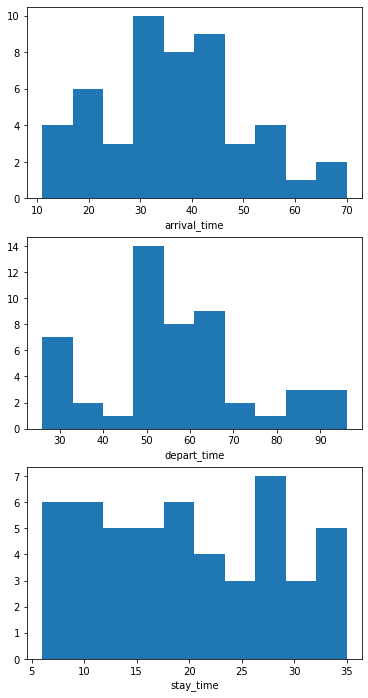

In [43]:
f, axs = plt.subplots(3, 1, figsize=(6, 12))
plt.subplot(3, 1, 1)
plt.hist(arrival_time, bins=10)
plt.xlabel("arrival_time")

plt.subplot(3, 1, 2)
plt.hist(depart_time, bins=10)
plt.xlabel("depart_time")

plt.subplot(3, 1, 3)
plt.hist(depart_time - arrival_time, bins=10)
plt.xlabel("stay_time")
plt.show()

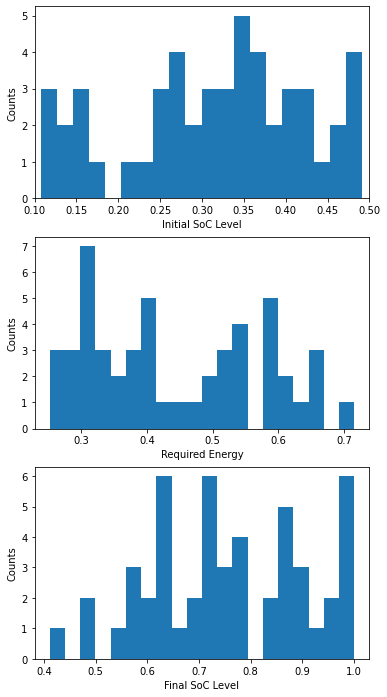

In [29]:
np.random.seed(0)
# initial battery energy level 10%~50%
initial_state=np.random.uniform(0.8, 4.0, size=(total_vehicles,))
# required energy 25%~75%
required_energy=np.random.uniform(2.0, 6.0, size=(total_vehicles,))
# final energy is upper bounded by the battery_capacity
final_energy = np.min((initial_state+required_energy, np.ones_like(initial_state)*battery_capacity), axis=0)
required_energy = np.round(final_energy-initial_state, 2)

# print("initial State", initial_state)
# print("Required energy", required_energy)
# print("Final state", final_energy)
fig, ax = plt.subplots(3, 1, figsize=(6, 12))
plt.subplot(3, 1, 1)
plt.hist(initial_state/8, bins=20)
plt.xlim([0.1, 0.5])
plt.xlabel("Initial SoC Level")
plt.ylabel("Counts")

plt.subplot(3, 1, 2)
plt.hist(required_energy/8, bins=20)
plt.xlabel("Required Energy")
plt.ylabel("Counts")

plt.subplot(3, 1, 3)
plt.hist(final_energy/8, bins=20)
plt.xlabel("Final SoC Level")
plt.ylabel("Counts")
plt.show()

In [38]:
initial_state = np.copy(initial_state)
u_mpc_online = np.zeros((total_vehicles, num_steps), dtype=float)
x_mpc_online = np.zeros((total_vehicles, num_steps+1), dtype=float)
x_mpc_online[:, 0:int(arrival_time[0])+2] = initial_state.reshape((-1, 1))

In [81]:
x,u = naive3(num_of_vehicles=total_vehicles, timesteps=num_steps, initial_states=initial_state, max_power=max_power, terminal_states=final_energy, arrival_time=arrival_time, dept_time=depart_time, power_capacity=power_capacity, decay_rate=decay_rate,aware=True)

In [62]:
final_energy

array([6.83699029, 6.84301203, 8.        , 4.95180543, 4.99120238,
       5.51209923, 6.81271238, 6.66684001, 7.74896393, 5.00471523,
       5.96939846, 4.93396431, 7.24306095, 6.31464105, 3.81364483,
       4.55371444, 6.14867179, 5.85278861, 8.        , 5.96843251,
       8.        , 7.23191221, 8.        , 7.71707544, 6.13553248,
       5.00449844, 4.38995837, 6.30372678, 5.65447542, 4.60182908,
       4.91851068, 6.93459978, 4.51627105, 7.38887711, 5.12653318,
       5.83799155, 6.85169853, 5.14995083, 8.        , 8.        ,
       5.22470109, 6.86814377, 5.55961128, 5.85803033, 6.09127786,
       5.67880663, 5.81927593, 3.29299434, 7.12513084, 3.98265637])

In [82]:
np.sum(final_energy)-np.sum(initial_state), np.sum(np.max(x,axis=1))-np.sum(x[:,0]), np.sum(u[:,:])

(177.35630831312125, 150.22975919069694, 150.22975919069694)

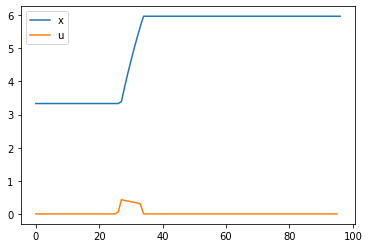

In [83]:
plt.plot(x[10,:],label='x')
plt.plot(u[10,:],label='u')
plt.legend()
plt.show()

In [1]:
np.random.uniform(0.8, 4.0, size=(total_vehicles,))

NameError: name 'np' is not defined

In [79]:
def naive3(num_of_vehicles, timesteps, initial_states, max_power, terminal_states, arrival_time, dept_time, power_capacity, decay_rate,aware=False):
    
    initial_states = np.copy(initial_states)
    u_mpc_online = np.zeros((num_of_vehicles, timesteps), dtype=float)
    x_mpc_online = np.zeros((num_of_vehicles, timesteps+1), dtype=float)
    x_mpc_online[:,:] = initial_states.reshape((-1, 1))
    if aware: max_u = max_power * np.ones((num_of_vehicles,)) - decay_rate * initial_states
    else: max_u = max_power

    for t in range(int(arrival_time[0]), timesteps-5):
        power_budget = power_capacity
        vehicle_ending_index = (arrival_time < t).sum()
        available_vehicle_idx = np.array([i for i in range(vehicle_ending_index) if dept_time[i] > t and x_mpc_online[i,t] < terminal_states[i]])
        if len(available_vehicle_idx) == 0:
            continue
        u_val = np.zeros((len(available_vehicle_idx),))
        charging_sesson = 0
        while power_budget >= 0:
            vehicle_idx = available_vehicle_idx[charging_sesson]
            if aware: available_charging = np.minimum(max_u[vehicle_idx], power_budget)
            else: available_charging = np.minimum(max_u, power_budget)
            #print(f'at time {t}, vehicle{vehicle_idx} can charge {available_charging}')
            available_charging = np.minimum(terminal_states[vehicle_idx]-x_mpc_online[vehicle_idx,t], available_charging)
            #print(f'at time {t}, vehicle{vehicle_idx} can charge {available_charging}')
            u_val[charging_sesson] = np.maximum(available_charging, 0)
            power_budget -= u_val[charging_sesson]
            # check availability
            u_hat = max_power - decay_rate*x_mpc_online[vehicle_idx, t]
            u_mpc_online[vehicle_idx,t] = np.minimum(u_hat, u_val[charging_sesson])
            x_mpc_online[vehicle_idx,t+1:] = x_mpc_online[vehicle_idx,t] + u_mpc_online[vehicle_idx,t]
            charging_sesson += 1
            if charging_sesson >= len(available_vehicle_idx):
                break
        #u_hat = max_power - decay_rate*x_mpc_online[available_vehicle_idx, t]
        #print(f'at time {t}, vehicle{vehicle_idx} can charge {u_hat}, the previous SoC is {x_mpc_online[available_vehicle_idx, t]}')
        #u_mpc_online[available_vehicle_idx,t] = np.minimum(u_hat[:], u_val[:])
        #print(u_val[:], u_hat, u_mpc_online[available_vehicle_idx,t])
        #x_mpc_online[available_vehicle_idx, t+1] = x_mpc_online[available_vehicle_idx, t] + u_mpc_online[available_vehicle_idx, t]

    return x_mpc_online, u_mpc_online

### Simple Online Algorithm

In [10]:
decay_rate = 0.05
power_budget = power_capacity 

for t in range(int(arrival_time[0]), num_steps-7):
    
    #Change this for variable case
    power_budget = power_capacity 

    print("Current time", t)

    ## Cars [1, ..., VEI] arrive before the scheduling time 
    vehicle_ending_index = (arrival_time <= t).sum()
    vehicle_starting_index = total_vehicles - (depart_time > t).sum()
    step_num_of_vehicles = vehicle_ending_index - vehicle_starting_index
    print("current number of arrived cars", vehicle_ending_index, "current number of charging cars", step_num_of_vehicles)
    
    ## Obtain initial energy level of all cars
    step_initial_SOC = np.copy(x_mpc_online[vehicle_starting_index:vehicle_ending_index, t])
    ## Obtain required energy level of all cars
    step_terminal_SOC = np.copy(terminal_state_MPC[vehicle_starting_index:vehicle_ending_index])
    
    ## Obtain arrival departure time for all current cars
    arrival_schedule=np.copy(arrival_time[vehicle_starting_index:vehicle_ending_index])
    depart_schedule=np.copy(depart_time[vehicle_starting_index:vehicle_ending_index])
    # print('initial soc', step_initial_SOC)
    # print('terminal soc', step_terminal_SOC)
    # print('arrival_schedule', arrival_schedule)
    # print('depart_schedule', depart_schedule)

    x_index, u_index = MPC_Solver(num_of_vehicles = step_num_of_vehicles, timesteps = num_steps-t, 
               initial_states = step_initial_SOC, terminal_states = step_terminal_SOC, 
               max_power = max_power, arrival_time = arrival_schedule-t, dept_time = depart_schedule-t, 
               power_capacity = power_budget, plot_fig = False)
    

    # compute the maximum charging rate (soc curve)
    u_hat = max_power - decay_rate*x_mpc_online[vehicle_starting_index:vehicle_ending_index, t]/battery_capacity

    u_mpc_online[vehicle_starting_index:vehicle_ending_index, t] = np.minimum(u_index[:, 0], u_hat)

Current time 11
current number of arrived cars 1 current number of charging cars 1


NameError: name 'x_mpc_online' is not defined

### Offline Algorithm

In [71]:
import cvxpy as cp
num_of_vehicles = total_vehicles
timesteps = num_steps 
initial_states = initial_state
terminal_states = final_energy
dept_time = depart_time

In [62]:
# Requested end SoC for all vehicles
x_terminal=cp.Parameter(num_of_vehicles, name='x_terminal')
# Initial SoC for all vehicles
x0 = cp.Parameter(num_of_vehicles, name='x0')
# Peak charging power for the infrastructure
max_sum_u = cp.Parameter(name='max_sum_u')
# Maximum charging power for each vehicle at each time step
u_max = cp.Parameter(name='u_max')
# SoC at each time step for each vehicle
x = cp.Variable((num_of_vehicles, timesteps+1), name='x')
# charging power at each time step for each vehicle
u = cp.Variable((num_of_vehicles, timesteps), name='u')

x_terminal.value=terminal_states
x0.value = initial_states
max_sum_u.value = power_capacity
u_max.value = max_power

In [63]:
obj = 0
decay_rate = 0.05
constr = [x[:,0] == x0, 
          x[:,-1] <= x_terminal]

for i in range(num_of_vehicles):
    constr += [x[i,1:] == x[i,0:timesteps] + u[i,:],
        u[i,:] >= 0,
    ]
    for t in range(timesteps):
      constr += [u[i, t] <= (u_max-decay_rate*x[i, t-1])*(t>=arrival_time[i]),
                 u[i, t] <= (u_max-decay_rate*x[i, t-1])*(t<dept_time[i]),
                 ]

for t in range (timesteps):
    constr += [
               cp.sum(u[0:num_of_vehicles,t]) <= power_capacity,
    ]
    obj += cp.sum(cp.log(u[:,t] + 0.0000001))

obj -= cp.norm(x[:, -1] - x_terminal, 2)
prob = cp.Problem(cp.Maximize(obj), constr)
prob.solve()

x_socmpc = x.value
u_socmpc = u.value

/Users/bb/opt/anaconda3/envs/ev1/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [83]:
obj = 0
constr = [x[:,0] == x0, 
          x[:,-1] <= x_terminal]

for i in range(num_of_vehicles):
    constr += [x[i,1:] == x[i,0:timesteps] + u[i,:],
        u[i,:] >= 0,
    ]
    for t in range(timesteps):
      constr += [u[i, t] <= (u_max[i])*(t>=arrival_time[i]),
                 u[i, t] <= (u_max[i])*(t<dept_time[i]),
                 ]

for t in range (timesteps):
    constr += [
               cp.sum(u[0:num_of_vehicles,t]) <= power_capacity,
    ]
    obj += cp.sum(cp.log(u[:,t] + 0.0000001))
    
obj -= cp.norm(x[:, -1] - x_terminal, 2)
prob = cp.Problem(cp.Maximize(obj), constr)
prob.solve()

x_mpc = x.value
u_mpc = u.value

/Users/bb/opt/anaconda3/envs/ev1/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [84]:
x_mpc_proj = np.zeros_like(x_mpc)
x_mpc_proj[:, 0] = x_mpc[:, 0]
u_mpc_proj = np.zeros_like(u_mpc)

## validate feasibility
for i in range(num_of_vehicles):
  for t in range(timesteps):
    u_hat = u_max.value - decay_rate*x_mpc_proj[i, t]
    if(u_mpc[i, t] >= u_hat+1e-5):
      u_mpc_proj[i, t] = u_hat
      print(f'time{t},vehicle{i} violates')
    else:
      u_mpc_proj[i, t] = u_mpc[i, t]
    
    x_mpc_proj[i, t+1] = x_mpc_proj[i, t] + u_mpc_proj[i, t]


time26,vehicle0 violates
time16,vehicle1 violates
time17,vehicle1 violates
time18,vehicle1 violates
time19,vehicle1 violates
time20,vehicle1 violates
time21,vehicle1 violates
time22,vehicle1 violates
time23,vehicle1 violates
time24,vehicle1 violates
time25,vehicle1 violates
time25,vehicle7 violates
time26,vehicle7 violates
time27,vehicle7 violates
time28,vehicle7 violates
time29,vehicle7 violates
time30,vehicle7 violates
time31,vehicle7 violates
time24,vehicle8 violates
time25,vehicle8 violates
time26,vehicle8 violates
time27,vehicle8 violates
time28,vehicle8 violates
time29,vehicle8 violates
time26,vehicle11 violates
time27,vehicle11 violates
time28,vehicle11 violates
time29,vehicle11 violates
time30,vehicle11 violates
time58,vehicle21 violates
time35,vehicle25 violates
time50,vehicle26 violates
time51,vehicle26 violates
time52,vehicle26 violates
time36,vehicle29 violates
time37,vehicle29 violates
time41,vehicle29 violates
time42,vehicle29 violates
time51,vehicle30 violates
time53,veh

In [66]:
print('Total energy delivery, soc MPC', np.sum(u_socmpc))

Total energy delivery, soc MPC 182.17698590062832


In [67]:
print('Total energy delivery, standard MPC', np.sum(u_mpc_proj))

Total energy delivery, standard MPC 179.7527718209887


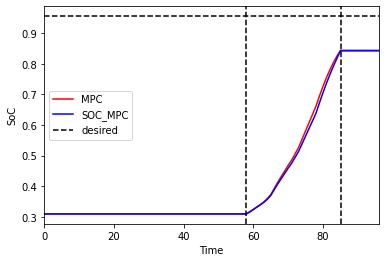

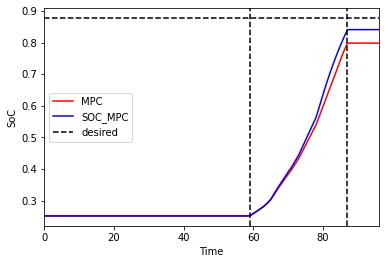

In [ ]:
for i in range(46, 48): #num_of_vehicles
  index = i
  plt.figure()
  plt.plot(x_mpc_proj[index]/battery_capacity, label = 'MPC', color = 'r')
  plt.plot(x_socmpc[index]/battery_capacity, label = 'SOC_MPC', color = 'b')
  plt.plot(final_energy[index]/battery_capacity*np.ones_like(x.value[0]), color='k', linestyle='--', label = 'desired')
  plt.axvline(x=arrival_time[index], color='k', linestyle='--')
  plt.axvline(x=dept_time[index], color='k', linestyle='--')
  plt.legend()
  plt.xlabel('Time')
  plt.xlim([0, 96])
  plt.ylabel('SoC')

Text(0, 0.5, 'charging power')

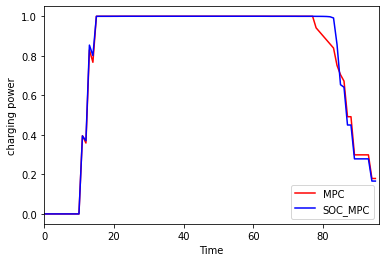

In [ ]:
plt.figure()
plt.plot(np.sum(u_mpc_proj, axis=0), label = 'MPC', color = 'r')
plt.plot(np.sum(u_socmpc, axis=0), label = 'SOC_MPC', color = 'b')
plt.legend()
plt.xlabel('Time')
plt.xlim([0, 96])
plt.ylabel('charging power')

In [24]:
np.zeros((4,))

array([0., 0., 0., 0.])

### Online Algorithm

In [ ]:
def MPC_Solver(num_of_vehicles, timesteps, initial_states, max_power,
               terminal_states, arrival_time, dept_time, power_capacity, plot_fig = False):
    
    # Requested end SoC for all vehicles
    x_terminal=cp.Parameter(num_of_vehicles, name='x_terminal')
    # Initial SoC for all vehicles
    x0 = cp.Parameter(num_of_vehicles, name='x0')
    # Peak charging power for the infrastructure
    max_sum_u = cp.Parameter(name='max_sum_u')
    # Maximum charging power for each vehicle at each time step
    u_max = cp.Parameter(num_of_vehicles, name='u_max')
    # SoC at each time step for each vehicle
    x = cp.Variable((num_of_vehicles, timesteps+1), name='x')
    # charging power at each time step for each vehicle
    u = cp.Variable((num_of_vehicles, timesteps), name='u')

    x_terminal.value=terminal_states
    x0.value = initial_states
    max_sum_u.value = power_capacity
    u_max.value = max_power * np.ones((num_of_vehicles, ))

    obj = 0
    constr = [x[:,0] == x0, 
              x[:,-1] <= x_terminal]

    for i in range(num_of_vehicles):
        constr += [x[i,1:] == x[i,0:timesteps] + u[i,:],
            u[i,:] >= 0,
        ]
        for t in range(timesteps):
          constr += [u[i, t] <= (u_max[i])*(t>=arrival_time[i]),
                    u[i, t] <= (u_max[i])*(t<dept_time[i]),
                    ]

    for t in range (timesteps):
        constr += [
                  cp.sum(u[0:num_of_vehicles,t]) <= power_capacity,
        ]
        obj += cp.sum(cp.log(u[:,t] + 0.0000001))

    obj -= cp.norm(x[:, -1] - x_terminal, 2)
    prob = cp.Problem(cp.Maximize(obj), constr)
    prob.solve(verbose=True)
    # obj = 0
    # constr = [x[:,0] == x0, 
    #           x[:,-1] <= x_terminal+0.00001]

    # for t in range(timesteps):
    #     constr += [x[:,t+1] == x[:,t] + u[:,t],
    #                u[:,t] <= u_max,
    #                u[:,t] >= 0,
    #                cp.sum(u[:,t]) <= power_capacity,
    #                u[:,t] <= (t*np.ones_like(dept_time)<dept_time)*100.0+0.000001]
    #     obj += cp.sum(cp.log(u[:,t]))
    # obj -= cp.norm(x[:, -1]-x_terminal, 2)
    # prob = cp.Problem(cp.Maximize(obj), constr)
    # prob.solve()


    # if plot_fig==True:
    #   plt.plot(x.value[0])
    #   plt.plot(u.value[0])
    #   plt.show()

    return x.value, u.value

In [6]:
initial_state_MPC = np.copy(initial_state)
terminal_state_MPC = np.copy(final_energy)
u_mpc_online = np.zeros((total_vehicles, num_steps), dtype=float)
x_mpc_online = np.zeros((total_vehicles, num_steps+1), dtype=float)
x_mpc_online[:, 0:int(arrival_time[0])+1] = initial_state_MPC.reshape((-1, 1))

In [19]:
len(np.array([1,2,3]))

3

In [15]:
decay_rate = 0.5

for t in range(int(arrival_time[0]), num_steps-7):
    #Change this for variable case
    power_budget = power_capacity 

    print("Current time", t)

    ## Cars [1, ..., VEI] arrive before the scheduling time 
    vehicle_ending_index = (arrival_time <= t).sum()
    vehicle_starting_index = total_vehicles - (depart_time > t).sum()
    step_num_of_vehicles = vehicle_ending_index - vehicle_starting_index
    print("current number of arrived cars", vehicle_ending_index, "current number of charging cars", step_num_of_vehicles)
    
    ## Obtain initial energy level of all cars
    step_initial_SOC = np.copy(x_mpc_online[vehicle_starting_index:vehicle_ending_index, t])
    ## Obtain required energy level of all cars
    step_terminal_SOC = np.copy(terminal_state_MPC[vehicle_starting_index:vehicle_ending_index])
    
    ## Obtain arrival departure time for all current cars
    arrival_schedule=np.copy(arrival_time[vehicle_starting_index:vehicle_ending_index])
    depart_schedule=np.copy(depart_time[vehicle_starting_index:vehicle_ending_index])
    # print('initial soc', step_initial_SOC)
    # print('terminal soc', step_terminal_SOC)
    # print('arrival_schedule', arrival_schedule)
    # print('depart_schedule', depart_schedule)

    x_index, u_index = MPC_Solver(num_of_vehicles = step_num_of_vehicles, timesteps = num_steps-t, 
               initial_states = step_initial_SOC, terminal_states = step_terminal_SOC, 
               max_power = max_power, arrival_time = arrival_schedule-t, dept_time = depart_schedule-t, 
               power_capacity = power_budget, plot_fig = False)
    

    # compute the maximum charging rate (soc curve)
    u_hat = max_power - decay_rate*x_mpc_online[vehicle_starting_index:vehicle_ending_index, t]/battery_capacity

    u_mpc_online[vehicle_starting_index:vehicle_ending_index, t] = np.minimum(u_index[:, 0], u_hat)
    
    x_mpc_online[vehicle_starting_index:vehicle_ending_index, t+1] = x_mpc_online[vehicle_starting_index:vehicle_ending_index, t] + u_mpc_online[vehicle_starting_index:vehicle_ending_index, t]


Current time 13
current number of arrived cars 1 current number of charging cars 1


NameError: name 'MPC_Solver' is not defined

In [23]:
np.min(np.array([1,1,1]),np.array([-1,4,3]))

TypeError: only integer scalar arrays can be converted to a scalar index

Text(0, 0.5, 'charging power')

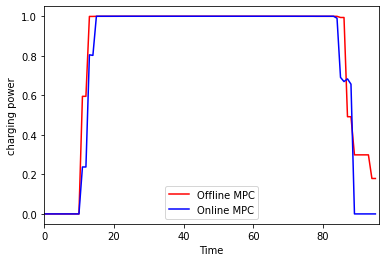

In [ ]:
plt.figure()
plt.plot(np.sum(u_mpc, axis=0), label = 'Offline MPC', color = 'r')
plt.plot(np.sum(u_mpc_online, axis=0), label = 'Online MPC', color = 'b')
plt.legend()
plt.xlabel('Time')
plt.xlim([0, 96])
plt.ylabel('charging power')

In [ ]:
#Consider SOC level for the maximum charging power
def MPC_SOC_Solver(num_of_vehicles, timesteps, initial_states,
                   max_power, terminal_states, dept_time,
                   power_capacity, decay_rate, plot_fig = False):

    x_terminal=cp.Parameter(num_of_vehicles, name='x_terminal')
    x0 = cp.Parameter(num_of_vehicles, name='x0')
    max_sum_u = cp.Parameter(name='max_sum_u')
    u_max = cp.Parameter(timesteps, name='u_max')
    x = cp.Variable((num_of_vehicles, timesteps+1), name='x')
    u = cp.Variable((num_of_vehicles, timesteps), name='u')

    x_terminal.value=terminal_states
    x0.value = initial_states
    max_sum_u.value = power_capacity
    u_max.value = max_power * np.ones((timesteps, ))

    obj = 0
    constr = [x[:,0] == x0, x[:,-1] <= x_terminal]

    for i in range(num_of_vehicles):
        constr +=[x[i,1:] == x[i,0:timesteps] + u[i,:],
            u[i,:] <= u_max,
            u[i,:] >= 0,
            u[i,:] <= (u_max[i]-decay_rate*x[i, :-1]/battery_capacity)
        ]

    for t in range (timesteps):
        constr += [
                   cp.sum(u[:,t]) <= max_sum_u,
                   u[:,t] <= (t*np.ones_like(dept_time)<dept_time)*100.0+0.000001,
        ]
        obj += cp.sum(cp.log(u[:,t]))

    obj -= cp.norm(x[:, -1] - x_terminal, 2)
    prob = cp.Problem(cp.Maximize(obj), constr)
    prob.solve()

    if plot_fig==True:
        plt.plot(x.value[0])
        plt.plot(u.value[0])
        plt.show()

    return x.value, u.value

In [ ]:
initial_state_MPCSOC = np.copy(initial_state)
terminal_state_MPCSOC = np.copy(final_energy)
u_mpcsoc_online = np.zeros((total_vehicles, num_steps), dtype=float)
x_mpcsoc_online = np.zeros((total_vehicles, num_steps+1), dtype=float)
x_mpcsoc_online[:, 0:int(arrival_time[0])+1] = initial_state_MPCSOC.reshape((-1, 1))

In [ ]:
decay_rate = 0.5

for t in range(int(arrival_time[0]), num_steps-7):
    #Change this for variable case
    power_budget = power_capacity 

    print("Current time", t)

    ## Cars [1, ..., VEI] arrive before the scheduling time 
    vehicle_ending_index = (arrival_time <= t).sum()
    vehicle_starting_index = total_vehicles - (depart_time > t).sum()
    step_num_of_vehicles = vehicle_ending_index - vehicle_starting_index
    print("current number of arrived cars", vehicle_ending_index, "current number of charging cars", step_num_of_vehicles)
    
    ## Obtain initial energy level of all cars
    step_initial_SOC = np.copy(x_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t])
    ## Obtain required energy level of all cars
    step_terminal_SOC = np.copy(terminal_state_MPCSOC[vehicle_starting_index:vehicle_ending_index])
    
    ## Obtain arrival departure time for all current cars
    arrival_schedule=np.copy(arrival_time[vehicle_starting_index:vehicle_ending_index])
    depart_schedule=np.copy(depart_time[vehicle_starting_index:vehicle_ending_index])
    # print('initial soc', step_initial_SOC)
    # print('terminal soc', step_terminal_SOC)
    # print('arrival_schedule', arrival_schedule)
    # print('depart_schedule', depart_schedule)

    x_index, u_index = MPC_SOC_Solver(num_of_vehicles = step_num_of_vehicles, timesteps = num_steps-t, 
               initial_states = step_initial_SOC, terminal_states = step_terminal_SOC, 
               max_power = max_power, dept_time = depart_schedule-t, 
               power_capacity = power_budget, decay_rate = decay_rate, plot_fig = False)
    

    # compute the maximum charging rate (soc curve)
    u_hat = max_power - decay_rate*x_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t]/battery_capacity

    u_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t] = np.minimum(u_index[:, 0], u_hat)
    
    x_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t+1] = (x_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t] 
                                                                         + u_mpcsoc_online[vehicle_starting_index:vehicle_ending_index, t])


Current time 11
current number of arrived cars 1 current number of charging cars 1
Current time 12
current number of arrived cars 1 current number of charging cars 1
Current time 13
current number of arrived cars 2 current number of charging cars 2
Current time 14
current number of arrived cars 2 current number of charging cars 2
Current time 15
current number of arrived cars 3 current number of charging cars 3
Current time 16
current number of arrived cars 4 current number of charging cars 4
Current time 17
current number of arrived cars 4 current number of charging cars 4
Current time 18
current number of arrived cars 4 current number of charging cars 4
Current time 19
current number of arrived cars 4 current number of charging cars 4
Current time 20
current number of arrived cars 5 current number of charging cars 5
Current time 21
current number of arrived cars 5 current number of charging cars 5
Current time 22
current number of arrived cars 10 current number of charging cars 10
Cu

Text(0, 0.5, 'charging power')

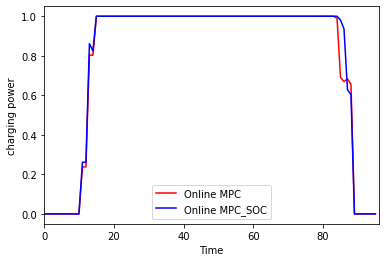

In [ ]:
plt.figure()
plt.plot(np.sum(u_mpc_online, axis=0), label = 'Online MPC', color = 'r')
plt.plot(np.sum(u_mpcsoc_online, axis=0), label = 'Online MPC_SOC', color = 'b')
plt.legend()
plt.xlabel('Time')
plt.xlim([0, 96])
plt.ylabel('charging power')

In [ ]:
print('Total energy delivery, soc MPC', np.sum(u_mpc_online))

Total energy delivery, soc MPC 74.77055150268424


In [ ]:
print('Total energy delivery, soc MPC', np.sum(u_mpcsoc_online))

Total energy delivery, soc MPC 75.35619444344334


In [ ]:
(np.sum(u_mpcsoc_online)-np.sum(u_mpc_online))/np.sum(u_mpc_online)

0.00783253472108035